### Importing Packages

### Loading Data:
Need to download actual dataset from https://drive.google.com/file/d/1vD4DtyJOIjRzchPtCQu-KPrUjgTiWSmo/view and unzip via Terminal (unzip NeuralNews.zip)

### Creating new environment to avoid clashes
python -m venv /Users/yzhao/ai4allc6g3

Step 1: Filtering to election based articles

In [183]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn import metrics
from sklearn.decomposition import PCA

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer

In [184]:
#LDA packages - issue: binary incompatibility
from gensim import corpora
from gensim.models import LdaModel

In [185]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /Users/yzhao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yzhao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yzhao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/yzhao/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [186]:
news_df = pd.read_csv("news_dataset.csv")
news_df.head()

,Labels,Articles
0,fake,A longtime champion of the homeless and batter...
1,fake,"Tucked away in the Marais, two warring groups ..."
2,fake,There are plenty of things that can impede wom...
3,fake,"New York City is home to more than 2,500 tiny ..."
4,fake,A man wearing a hat emblazoned with the words ...


In [187]:
news_df.shape

(64000, 2)

In [188]:
snowballStem = SnowballStemmer(language="english")
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

## Vectorizer and Bag of Words Approach

In [189]:
# Convert all articles to lowercase
news_df['Articles'] = [article.lower()for article in news_df["Articles"]]
news_df['Articles'].iloc[:5]

0    a longtime champion of the homeless and batter...
1    tucked away in the marais, two warring groups ...
2    there are plenty of things that can impede wom...
3    new york city is home to more than 2,500 tiny ...
4    a man wearing a hat emblazoned with the words ...
Name: Articles, dtype: object

In [190]:
# Filter the articles to only political articles
filtered_df = news_df[news_df["Articles"].str.contains(""" election|
             campaign| vote| ballot| voting| polling| candidate| nominee| politician|
             leader| opposition| incumbent| poll| polling| approval rating|
             electorate| conservative| liberal| democrat| republican| left-wing|
             right-wing| centrist| far-right| far-left| populist|
             governor| mayor| senator| representative| joe biden| bernie sanders| 
             elizabeth warren| pete buttigieg| andrew yang| tulsi gabbard| 
             kamala harris""", case=False)]

# Clean the labels column into fake (AI generated) versus not fake (human generated)
filtered_df.reset_index(drop=True, inplace=True)
filtered_df.loc[filtered_df["Labels"] == "fake", "Labels"] = 1
filtered_df.loc[filtered_df["Labels"] == "real", "Labels"] = 0
filtered_df = filtered_df.rename(columns={'Labels': 'Fake', 'Articles':'Article'})
filtered_df["Fake"] = filtered_df["Fake"].astype(int)
print(f'The shape of the filtered data frame is: {filtered_df.shape}')
print (f"Number of real articles {filtered_df.shape[0] - sum(filtered_df['Fake'])}")
print (f"Number of AI generated articles {sum(filtered_df['Fake'])}")

The shape of the filtered data frame is: (17278, 2)
Number of real articles 8618
Number of AI generated articles 8660


In [191]:
unprocessed_ai = pd.DataFrame(filtered_df[filtered_df['Fake']==1])
unprocessed_real = pd.DataFrame(filtered_df[filtered_df['Fake']==0])
fake_unprocessed_sample = unprocessed_ai.sample(5000)
real_unprocessed_sample = unprocessed_real.sample(5000)

In [192]:
def text_preprocessing(article):
    """
    article(string): Text to be cleaned for text analysis
    A function that accepts article and removes the punctuation, pronouns,
    and commonly used words that don't provide additional information such as 
    'the', 'a', etc.
    """
    # Remove punctuation
    article = ''.join([char for char in article if char not in string.punctuation])
    # Lemmatization of all non-stop words
    article = ' '.join([lemmatizer.lemmatize(word) for word in article.split() 
                        if word.isalpha() and word not in stop_words])
    
    return article
filtered_df["Cleaned_Article"] = filtered_df["Article"].apply(text_preprocessing)

In [193]:
filtered_df["Cleaned_Article"] = filtered_df["Cleaned_Article"].astype("string")

In [194]:
ai_articles = pd.DataFrame(filtered_df[filtered_df['Fake']==1])
real_articles = pd.DataFrame(filtered_df[filtered_df['Fake']==0])

fake_processed_sample = ai_articles.sample(n=5000)
real_processed_sample = real_articles.sample(n=5000)

### Word Frequency Analysis
Are there differences in human word choice and AI word choice? Are there any behavioral trends in term frequency?

In [195]:
# Create a bag of words for AI-Generated articles and non-AI generated articles
count_vectorizer = CountVectorizer()
count_vectorizer.fit(filtered_df["Cleaned_Article"])

CountVectorizer()

In [196]:
AI_bag_words = count_vectorizer.transform(fake_processed_sample["Cleaned_Article"])
real_bag_words = count_vectorizer.transform(real_processed_sample["Cleaned_Article"])
AI_word_counts = pd.DataFrame({'word': count_vectorizer.get_feature_names_out(), 
                               'count': AI_bag_words.toarray().sum(axis=0)})
real_word_counts = pd.DataFrame({'word': count_vectorizer.get_feature_names_out(),
                                'count': real_bag_words.toarray().sum(axis=0)})

In [197]:
AI_word_counts.sort_values(by='count', ascending=False, inplace=True)
AI_word_counts.head(20)

,word,count
86470,said,9343
67551,new,7617
110244,would,5711
95063,state,5313
65275,mr,5169
70842,one,5076
100743,time,5054
78013,president,5029
110921,year,4866
102633,trump,4782


In [198]:
real_word_counts.sort_values(by='count', ascending=False, inplace=True)
real_word_counts.head(20)

,word,count
65275,mr,24106
86470,said,23644
110244,would,8420
110921,year,7612
70842,one,7251
67551,new,6754
95063,state,6550
74275,people,5644
56562,like,5480
3008,also,4910


In [199]:
words_unique_AI = AI_word_counts[~AI_word_counts['word'].isin(real_word_counts['word'])]
print (f"The number of words that are used by the AI and not humans is {words_unique_AI.shape[0]}")
unique_real_words = real_word_counts[~real_word_counts['word'].isin(AI_word_counts['word'])]
print (f"The number of words that are used by the humans and not AI is {unique_real_words.shape[0]}")

The number of words that are used by the AI and not humans is 0
The number of words that are used by the humans and not AI is 0


From these two dataframes of most frequently used words and their respective word count, we can observe that the human use of honorifics (Mr) is approximately 380 times more than that of AI. However, outside of this, there seems to be many overlaps between common words. 

In addition, human-generated articles has higher word counts than AI-generated word count. On average, is article length insightful for differentiating between an AI-generated article and human generated article?

In [200]:
fake_unprocessed_sample["Word_Count"] = fake_unprocessed_sample["Article"].apply(lambda n: len(n.split()))
real_unprocessed_sample["Word_Count"] = real_unprocessed_sample["Article"].apply(lambda n: len(n.split()))
print(f"""On average, AI-Generated articles has approximately 
      {fake_unprocessed_sample['Word_Count'].mean():.2f} words per article.""")
print(f"""On average, non AI-Generated articles has approximately 
      {real_unprocessed_sample['Word_Count'].mean():.2f} words per article.""")

On average, AI-Generated articles has approximately 
      432.95 words per article.
On average, non AI-Generated articles has approximately 
      571.36 words per article.


In [201]:
fake_processed_sample["Word_Count"] = fake_processed_sample["Cleaned_Article"].apply(lambda n: len(n.split()))
real_processed_sample["Word_Count"] = real_processed_sample["Cleaned_Article"].apply(lambda n: len(n.split()))
print(f"""On average, AI-Generated articles has approximately 
      {fake_processed_sample['Word_Count'].mean():.2f} words per article.""")
print(f"""On average, non AI-Generated articles has approximately 
      {real_processed_sample['Word_Count'].mean():.2f} words per article.""")

On average, AI-Generated articles has approximately 
      227.23 words per article.
On average, non AI-Generated articles has approximately 
      320.01 words per article.


From above, we can discover that on average non AI-Generated articles has approximately 80 more words than AI-Generated articles.

Do the non AI-Generated articles contain more jargon and fluff? How can we use ngram analysis to analyze the particular context the the words in the dictionaries are used?

In [202]:
def get_ngram3(article, num):
    tokens = article.split()
    ngram_token = list(ngrams(tokens, num))
    counts = Counter(ngram_token)
    return counts

def combine_ngram_frequencies(articles, num, fake):
    """
    articles(string): A column of text to be used for n-gram analysis
    num (positive, non-zero integer): The amount of words per tuple used for 
    analysis
    fake (1 or 0): Indicates if the column of articles inputted are fake 
    (AI-Generated) or not. Should be 1 if the articles are AI-Generated. Should
    be 0 if the articles are human composed.

    Returns a dataframe containing cumulative n-gram tuples, frequencies, and
    source (whether the n-gram tuples are from AI-generated sources or not).
    """
    assert isinstance(num, int)
    combined_counts = Counter()
    
    for article in articles:
        counts = get_ngram3(article, num)
        combined_counts.update(counts)
    
    # Convert the combined counts to a DataFrame
    freq_df = pd.DataFrame(combined_counts.items(), columns=[f'{num}gram', 'frequency'])
    freq_df["fake"] = fake

    # Ensure the frequency column is of type int
    freq_df['frequency'] = freq_df['frequency'].astype(int)

    # Convert the n-gram tuples to strings for better readability
    freq_df[f'{num}gram'] = freq_df[f'{num}gram'].apply(lambda x: ' '.join(x))

    # Sort the DataFrame by frequency in descending order
    freq_df = freq_df.sort_values(by='frequency', ascending=False)
    freq_df.reset_index(inplace=True, drop=True)
    return freq_df

In [203]:
unprocessed_fake_5gram = combine_ngram_frequencies(
    fake_unprocessed_sample["Article"], 5, 1
    )
unprocessed_real_5gram = combine_ngram_frequencies(real_unprocessed_sample["Article"], 5, 0)

In [204]:
merged_unprocessed = pd.concat([unprocessed_fake_5gram, unprocessed_real_5gram])
merged_unprocessed = merged_unprocessed.sort_values(by="frequency", ascending=False)
merged_unprocessed.reset_index(inplace=True, drop=True)
top75 = merged_unprocessed.head(75)
top75.head(11)

,5gram,frequency,fake
0,read the full story at,1089,1
1,the full story at the,761,1
2,the new york times. related,300,1
3,full story at the new,294,1
4,story at the new york,294,1
5,at the new york times.,294,1
6,full story at the washington,128,1
7,at the washington post. related,125,1
8,story at the washington post.,125,1
9,story at the guardian. related,101,1


In [205]:
top250 = merged_unprocessed.head(250)
top250_pivoted = top250.pivot(index='5gram', columns='fake', values='frequency').fillna(0)
top250_pivoted.columns = ["real", "AI"]
top250_pivoted.head()

,real,AI
5gram,,
"""at the end of the",18.0,0.0
(a conversation with cbs california),0.0,44.0
"308 west 46th street, clinton,",16.0,0.0
"339 west 47th street, clinton,",15.0,0.0
"340 west 50th street, clinton,",19.0,0.0


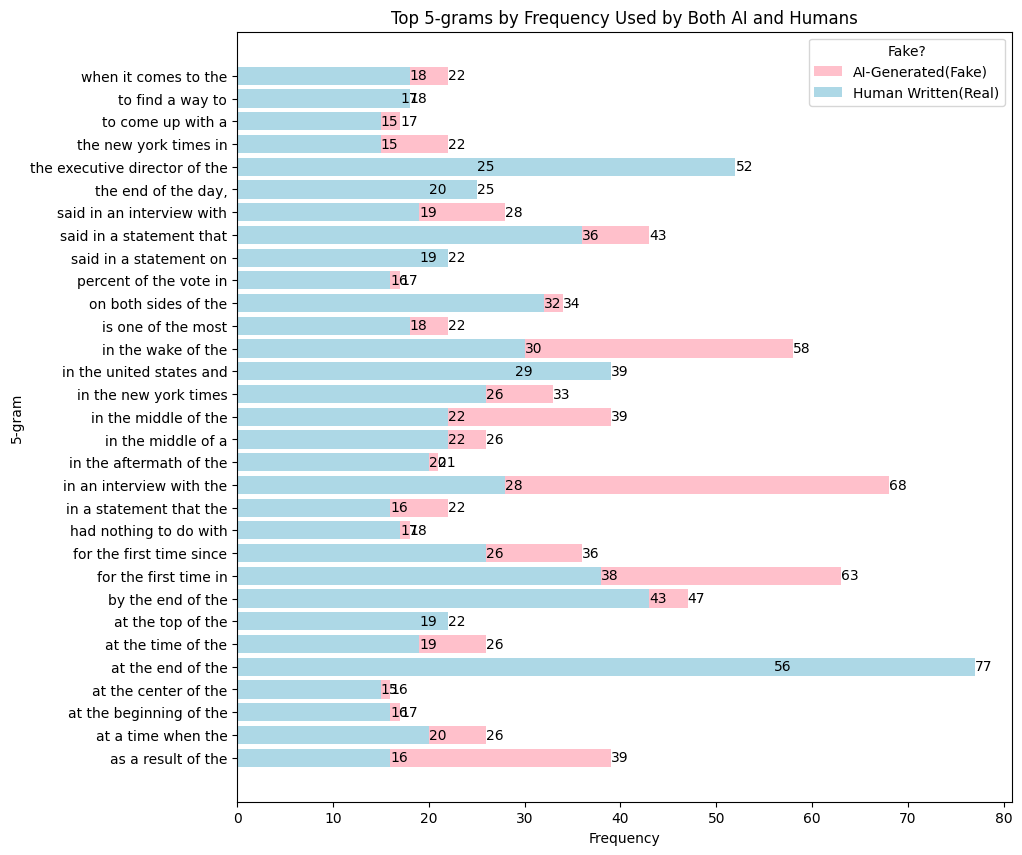

In [206]:
top250_overlap = top250_pivoted[(top250_pivoted["real"] != 0.0) & top250_pivoted["AI"] !=0]
# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

bars_fake = ax.barh(top250_overlap.index, top250_overlap["AI"], color='pink', label='AI-Generated(Fake)')
bars_real = ax.barh(top250_overlap.index, top250_overlap["real"], color='lightblue', label='Human Written(Real)')

# Add labels to each bar
for bars in [bars_real, bars_fake]:
    ax.bar_label(bars, fmt='{:,.0f}')

# Set plot title and labels
plt.title("Top 5-grams by Frequency Used by Both AI and Humans")
plt.xlabel("Frequency")
plt.ylabel("5-gram")
plt.legend(title="Fake?")
#plt.tight_layout()

# Show the plot
plt.show()


In [207]:
fivegram_unique_AI = pd.DataFrame(unprocessed_fake_5gram[~unprocessed_fake_5gram['5gram'].isin(unprocessed_real_5gram['5gram'])])
print (f"The number of words that are used by the AI and not humans is {fivegram_unique_AI.shape[0]}")
fivegram_unique_real = pd.DataFrame(unprocessed_real_5gram[~unprocessed_real_5gram['5gram'].isin(unprocessed_fake_5gram['5gram'])])
print (f"The number of words that are used by the humans and not AI is {fivegram_unique_real.shape[0]}")

The number of words that are used by the AI and not humans is 2085140
The number of words that are used by the humans and not AI is 2768560


In [208]:
fivegram_unique_AI.sort_values(by="frequency", ascending=False, inplace=True)
fivegram_unique_AI.reset_index(inplace=True, drop=True)
fivegram_unique_AI.head(20)

,5gram,frequency,fake
0,read the full story at,1089,1
1,the full story at the,761,1
2,the new york times. related,300,1
3,full story at the new,294,1
4,story at the new york,294,1
5,full story at the washington,128,1
6,at the washington post. related,125,1
7,story at the washington post.,125,1
8,story at the guardian. related,101,1
9,full story at the guardian.,101,1


In [209]:
fivegram_unique_real.sort_values(by="frequency", ascending = False, inplace=True)
fivegram_unique_real.reset_index(inplace=True, drop=True)
fivegram_unique_real.head(20)

,5gram,frequency,fake
0,"street, clinton, (212) 239-6200, telecharge.com.",78,0
1,"west 45th street, (212) 239-6200,",38,0
2,"45th street, (212) 239-6200, telecharge.com.",37,0
3,"west 42nd street, clinton, (212)",36,0
4,"street, (212) 239-6200, telecharge.com. (brant...",36,0
5,"west 44th street, (212) 239-6200,",31,0
6,vice president joseph r. biden,30,0
7,"44th street, (212) 239-6200, telecharge.com.",29,0
8,secretary of state hillary rodham,21,0
9,president joseph r. biden jr.,20,0


In [210]:
# top65 = pd.DataFrame(top75.iloc[11:,:])
# top65.reset_index(inplace=True, drop=True)
# top65
# plt.figure(figsize=(10, 8))

# gram_freq_plot = sns.barplot(
#     data=top65,
#     x="frequency",
#     y="5gram",
#     hue="fake",
#     dodge=False
# )

# for container in gram_freq_plot.containers:
#     gram_freq_plot.bar_label(container, fmt='{:,.0f}')

# plt.title("Top 5-grams by Frequency (Human Written(Real) vs. AI-Generated(Fake) Articles)")
# plt.xlabel("Frequency")
# plt.ylabel("5-gram")
# plt.legend(title="Fake?")
# plt.tight_layout()
# plt.show()

In [211]:
# pivot_df_top65 = top65.pivot(index='5gram', columns='fake', values='frequency').fillna(0)
# pivot_df_top65.columns = ["real", "AI"]
# pivot_df_top65.sort_values(by = "AI", ascending= False, inplace=True)
# pivot_df_top65.head()

# pivot_df_top65[(pivot_df_top65["real"] != 0.0) & pivot_df_top65["AI"] !=0]
# pivot_df_top65[pivot_df_top65["real"] == 0.0]
# pivot_df_top65[pivot_df_top65["AI"] == 0.0]

In [212]:
# # Create the figure and axis
# fig, ax = plt.subplots(figsize=(10, 10))

# # Plot the bars for 'real' articles
# bars_real = ax.barh(pivot_df_top65.index, pivot_df_top65["real"], color='lightblue', label='Human')

# # Plot the bars for 'fake' articles on top of the 'real' bars
# bars_fake = ax.barh(pivot_df_top65.index, pivot_df_top65["AI"], left=pivot_df_top65["real"], color='pink', label='AI')

# # Add labels to each bar
# for bars in [bars_real, bars_fake]:
#     ax.bar_label(bars, fmt='{:,.0f}')

# # Set plot title and labels
# plt.title("Top 5-grams by Frequency (Human Written(Real) vs. AI-Generated(Fake) Articles)")
# plt.xlabel("Frequency")
# plt.ylabel("5-gram")
# plt.legend(title="Fake?")
# #plt.tight_layout()

# # Show the plot
# plt.show()


In [213]:
# def get_ngram(article, num):
#     tokens = article.split()
#     ngram_token = list(ngrams(tokens, num))
#     return ngram_token

# def get_ngram2(article, num):
#     assert isinstance(num, int)
#     tokens = article.split()

#     ngram_token = list(ngrams(tokens, num))

#     counts = Counter(ngram_token)
#     freq_df = pd.DataFrame(counts.items(), columns=[f'{num}gram', 'frequency'])

#     freq_df['frequency'] = freq_df['frequency'].astype(int)
#     freq_df[f'{num}gram'] = freq_df[f'{num}gram'].astype(str)
#     freq_df = freq_df.sort_values(by='frequency', ascending=False)
#     freq_df.reset_index(inplace=True, drop = True)
#     print (freq_df.head(20))
#     print (freq_df.shape)
#     return freq_df

In [214]:
# top30_fake = pd.DataFrame(f_trigram_df.iloc[:30,])
# top30_fake["source"] = "fake"
# top30_real = pd.DataFrame(r_trigram_df.iloc[:30,])
# top30_real["source"] = "real"
# merged_top30 = pd.concat([top30_real, top30_fake])
# merged_top30 = merged_top30.sort_values(by="frequency", ascending=False)
# merged_top30.head()

In [215]:
# ftest_df["5gram"] = ftest_df["Cleaned_Article"].apply(lambda x: get_ngram(x, 5))
# f_all_trigrams = sum(ftest_df['5gram'], [])
# f_trigram_counts = Counter(f_all_trigrams)
# f_trigram_df = pd.DataFrame(f_trigram_counts.items(), columns=['5gram', 'frequency'])
# f_trigram_df['frequency'] = f_trigram_df['frequency'].astype(int)
# f_trigram_df = f_trigram_df.sort_values(by='frequency', ascending=False)
# f_trigram_df.reset_index(inplace=True, drop = True)
# f_trigram_df['5gram'] = f_trigram_df['5gram'].astype("string")
# f_trigram_df.head()
# rtest_df["5gram"] = rtest_df["Cleaned_Article"].apply(lambda x: get_ngram(x, 5))
# r_all_trigrams = sum(rtest_df['5gram'], [])
# r_trigram_counts = Counter(r_all_trigrams)
# r_trigram_df = pd.DataFrame(r_trigram_counts.items(), columns=['5gram', 'frequency'])
# r_trigram_df['frequency'] = r_trigram_df['frequency'].astype(int)
# r_trigram_df = r_trigram_df.sort_values(by='frequency', ascending=False)
# r_trigram_df.reset_index(inplace=True, drop = True)
# r_trigram_df['5gram'] = r_trigram_df['5gram'].astype("string")
# r_trigram_df.head()

In [216]:
# def extract_ngrams(data, n):
#     n_grams = ngrams(nltk.word_tokenize(data), n)
#     n_counter = Counter(n_grams)
#     freq = pd.DataFrame(n_counter.items(), columns=["Words", "Frequency"]).sort_values(by = "Frequency")
#     return freq

# ai_two_gram = pd.concat(ai_articles["Cleaned_Article"].apply(lambda x: extract_ngrams(x, 2)))
# accumulated_ngrams = ai_two_gram.groupby("Words", as_index=False).sum()
# accumulated_ngrams.head()

# accumulated_ngrams.shape

<!-- ai_two_gram['Words'] = ai_articles["Cleaned_Article"].apply(lambda x: extract_ngrams(x, 2))
ai_two_gram['Frequency'] = Counter()
ai_three_gram['3_gram'] = ai_articles["Cleaned_Article"].apply(lambda x: extract_ngrams(x, 3))
ai_articles['4_gram'] = ai_articles["Cleaned_Article"].apply(lambda x: extract_ngrams(x, 4))

two_gram['2_gram'] = real_articles["Cleaned_Article"].apply(lambda x: extract_ngrams(x, 2))
real_articles['3_gram'] = real_articles["Cleaned_Article"].apply(lambda x: extract_ngrams(x, 3))
real_articles['4_gram'] = real_articles["Cleaned_Article"].apply(lambda x: extract_ngrams(x, 4)) -->

### KMeans Clustering with Inverse Document Frequency (IDF)Normalization 
References Used: https://scikit-learn.org/1.5/auto_examples/text/plot_document_clustering.html

In [217]:
vectorizer = TfidfVectorizer(max_df=0.90, min_df=5, stop_words="english")
processed_merged_df = pd.concat([real_processed_sample, fake_processed_sample])
X_tfidf = vectorizer.fit_transform(processed_merged_df["Cleaned_Article"])
print(processed_merged_df.shape)

(10000, 4)


In [218]:
X_tfidf

<10000x22836 sparse matrix of type '<class 'numpy.float64'>'
	with 1665694 stored elements in Compressed Sparse Row format>

#embed document into array and project them into an emeddy space -> PCA (reduce densionaly) -> noticiable cluster
#clustering document embedding

In [219]:
# True labels for evaluation
labels = processed_merged_df["Fake"].tolist()
evaluations = []
evaluations_std = []

# Define the evaluation function
def fit_and_evaluate(km, X, labels, name=None, n_runs=5):
    name = km.__class__.__name__ if name is None else name
    scores = defaultdict(list)
    
    for seed in range(n_runs):
        km.set_params(random_state=seed)
        km.fit(X)
        scores["Homogeneity"].append(metrics.homogeneity_score(labels, km.labels_))
        scores["Completeness"].append(metrics.completeness_score(labels, km.labels_))
        scores["V-measure"].append(metrics.v_measure_score(labels, km.labels_))
        scores["Adjusted Rand-Index"].append(metrics.adjusted_rand_score(labels, km.labels_))
        scores["Silhouette Coefficient"].append(metrics.silhouette_score(X, km.labels_, sample_size=2000))
    
    evaluation = {"estimator": name}
    evaluation_std = {"estimator": name}
    
    for score_name, score_values in scores.items():
        mean_score, std_score = np.mean(score_values), np.std(score_values)
        print(f"{score_name}: {mean_score:.3f} ± {std_score:.3f}")
        evaluation[score_name] = mean_score
        evaluation_std[score_name] = std_score
    
    evaluations.append(evaluation)
    evaluations_std.append(evaluation_std)


In the function above, five scores commonly used to evaluate clustering algorithms are used. 

**Homogeneity**: Measures if each cluster contains only members of a single class. A low score (close to 0) indicates that the clusters are not homogeneous, meaning that the clusters contain a mix of different classes.

**Completeness**: Measures if all members of a given class are assigned to the same cluster. A low score (close to 0) suggests that the members of each class are spread across multiple clusters, indicating poor clustering performance.

**V-measure**: The harmonic mean of homogeneity and completeness. A low V-measure indicates that both homogeneity and completeness are low, reflecting poor overall clustering quality.

**Adjusted Rand-Index**: Measures the similarity between the true labels and the clustering labels, adjusted for chance. A low score (close to 0) indicates that the clustering results are not much better than random assignment.

**Silhouette Coefficient**: Measures how similar an object is to its own cluster compared to other clusters. A low score (close to 0) suggests that the clusters are not well-separated, and the data points are not well-clustered.

In [220]:
kmeans = KMeans(n_clusters=2)
fit_and_evaluate(kmeans, X_tfidf, labels=labels, name="KMeans on tf-idf vectors")

Homogeneity: 0.016 ± 0.003
Completeness: 0.020 ± 0.004
V-measure: 0.018 ± 0.003
Adjusted Rand-Index: 0.016 ± 0.003
Silhouette Coefficient: 0.003 ± 0.000


As shown above, when it's set to two clusters and initialized using the greedy kmeans++ and the distribution of the points, it does not perform well. The purity of resulting clusters are low and the algorthm is not accurately clustering the article. To address this, possible steps could be to tune the parameters and use principal component analysis to reduce the amount of dimensions.

First, I will experiment with the initialization of the centriods and setting it to random, where the inital centroids will be randomly selected. 

In [221]:
kmeans = KMeans(n_clusters=2, init = "random")
fit_and_evaluate(kmeans, X_tfidf, labels=labels, name="KMeans on tf-idf vectors")

Homogeneity: 0.015 ± 0.001
Completeness: 0.018 ± 0.001
V-measure: 0.016 ± 0.001
Adjusted Rand-Index: 0.016 ± 0.001
Silhouette Coefficient: 0.003 ± 0.000


From the above values, we can see that randomly initializing the centroid did help with increasing the evaluation metrics. Using the random centriod initialization method, how would the changing the number of independent runs change this? 
When using a random centriod initialization method, the algorithm runs 10 times and the best output is returned. 
Would increasing the amount of times the algorithm is run enhance the performance?

include code here for graph where x is value for n_init and y is the graphs with the above scores

perhaps add article length as another covariate

In [222]:
kmeans = KMeans(n_clusters=2, max_iter=100, n_init="auto")
fit_and_evaluate(kmeans, X_tfidf, labels=labels, name="KMeans on tf-idf vectors")

Homogeneity: 0.016 ± 0.003
Completeness: 0.020 ± 0.004
V-measure: 0.018 ± 0.003
Adjusted Rand-Index: 0.016 ± 0.003
Silhouette Coefficient: 0.003 ± 0.000


In [223]:
# fake_tfidf = tfidf_vectorizer.fit_transform(filtered_df["Cleaned_Article"])
# tfidf_vocabulary = tfidf_vectorizer.get_feature_names_out()
# count_vocabulary = count_vectorizer.get_feature_names_out(word_counts)
# size_tfidf = tfidf_vocabulary.shape[0]
# size_vocab = count_vocabulary.shape[0]
# size_compare = np.round(size_tfidf / size_vocab, 2)
# print ("Size of tfidf vocabulary is " + str(size_compare) +
#       " of the overall vocabulary.")
# print (tfidf_vocabulary)

### Principal Component Analysis Dimension Reduction
Using the vectorized text our data from the section, above, we want to apply PCA to reduce the dimension of our model to reduce variability from large dimension.
can't evaluate text as a factor
appoarch for text:
- labeled -> what are the most similar nouns? let's look at the actually words with fake (word cloud) 
- run cluster using LDA and see what default  (run together and separately and see topic differences)
- extended: grammar and personal (read about it and put into project)
- so much text -> maybe need to isolate specific words -> but may not be helpful  -> ask for example from Amish
- try to running with a smaller sample

In [224]:
#pca = PCA()
#pca.fit(X_tfidf)
#pca.explained_variance_ratio_

### LDA Analysis
https://developer.ibm.com/tutorials/awb-lda-topic-modeling-text-analysis-python/

In [225]:
from gensim import matutils
from gensim import corpora
from gensim.models import LdaModel
from gensim.models import LdaMulticore
import pyLDAvis.gensim_models as gensimvisualize
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from pprint import pprint

In [226]:
corpus = matutils.Sparse2Corpus(X_tfidf, documents_columns=False)
id2word = corpora.Dictionary(processed_merged_df["Cleaned_Article"].apply(lambda x: x.split()))

In [227]:
lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=2)

# View the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

python(56055) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56056) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56057) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56058) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56059) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56060) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56062) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[(0,
  '0.003*"nyack" + 0.002*"gravano" + 0.001*"blands" + 0.001*"companysponsored" '
  '+ 0.001*"swaggering" + 0.001*"lagarde" + 0.001*"simmons" + '
  '0.001*"ribboncutting" + 0.001*"surplus" + 0.001*"theatrebedlamorg"'),
 (1,
  '0.003*"nyack" + 0.002*"gravano" + 0.001*"swaggering" + 0.001*"surplus" + '
  '0.001*"companysponsored" + 0.001*"blands" + 0.001*"lagarde" + '
  '0.001*"simmons" + 0.001*"ribboncutting" + 0.001*"flexible"')]


In [228]:
# lda = LatentDirichletAllocation(n_components=2, random_state=2950)
# lda.fit(X_tfidf)
# X_topics = lda.transform(X_tfidf)
# terms = vectorizer.get_feature_names_out()
# for idx, topic in enumerate(lda.components_):
#     print(f"Topic {idx}:")
#     print(" ".join([terms[i] for i in topic.argsort()[-10:]]))

In [229]:
feature_names = vectorizer.get_feature_names_out()
word_frequencies = np.asarray(X_tfidf.sum(axis=0)).flatten()
id2word = corpora.Dictionary([feature_names])
id2word.filter_extremes(no_below=5, no_above=0.9)

In [230]:
frequency_dict = dict(zip(feature_names, word_frequencies))
frequency_dict

{'aa': 0.6354156138388013,
 'aaa': 0.7788889844001976,
 'aaron': 5.414348808186299,
 'aarp': 0.9289793325077269,
 'ab': 0.4935551310990959,
 'aback': 1.0825843786894431,
 'abadi': 1.072254449032798,
 'abalone': 0.27316765796208714,
 'abandon': 5.663309849863058,
 'abandoned': 8.315982091780622,
 'abandoning': 2.7623275306825894,
 'abandonment': 1.2044574329184312,
 'abatement': 0.802552011373903,
 'abba': 0.16556607091361292,
 'abbas': 4.40855829363791,
 'abbe': 0.30318567671015484,
 'abbey': 1.0822474005373512,
 'abbott': 5.601717580122627,
 'abbottabad': 0.2691389304722962,
 'abbotts': 0.8570637687088224,
 'abbreviated': 0.5291025457313249,
 'abby': 0.9189199791476692,
 'abc': 9.88574797327557,
 'abdel': 3.7644981597252776,
 'abdication': 0.4158785920185538,
 'abdu': 0.5019192126556484,
 'abducted': 1.701025607570307,
 'abduction': 0.889010684495671,
 'abdul': 3.5589514551776524,
 'abdullah': 6.83207674778029,
 'abdullahs': 0.45583395092091417,
 'abe': 5.958740918567599,
 'abedin': 1

In [232]:
#https://yanlinc.medium.com/how-to-build-a-lda-topic-model-using-from-text-601cdcbfd3a6
# lda_model = LatentDirichletAllocation(n_components=20, max_iter=10, 
#                                       learning_method='online', random_state=100, 
#                                       batch_size=128, evaluate_every = -1, 
#                                       n_jobs = -1)
# lda_output = lda_model.fit_transform(X_tfidf)
# print(lda_model)  # Model attributes

### Classification of article party alignment

In [ ]:
# installs used 
# pip install transformers
# pip install ipywidgets
# pip3 install torch torchvision torchaudio (may vary based on device)
# pip install tensorflow
# pip install tf_keras
# Load model directly
# from transformers import AutoTokenizer, AutoModelForMaskedLM, pipeline

# pipe = pipeline("text-classification", model="launch/POLITICS")
# news_sample = news_df.sample(n = 10)
# def classify_party(article):
#     result = pipe(article)[0]
#     return (pd.Series([result['label'], result['score']]))
# def find_leng(article):
#     return (len(article.split()) < 500)
# short_articles = news_sample[news_sample["Cleaned_Article"].apply(find_leng)]
# short_articles
#short_articles.shape
#for article in short_articles["Cleaned_Article"]:
    #if (len(article.split()) >= 512):
        # print (len(article.split()))
#short_articles[['label', 'confidence']] = short_articles['Cleaned_Article'].apply(classify_party)
#tokenizer = AutoTokenizer.from_pretrained("launch/POLITICS")
#model = AutoModelForMaskedLM.from_pretrained("launch/POLITICS")
#encoded = short_articles['Cleaned_Article'].apply(tokenizer, return_tensors="pt")
# text = short_articles['Cleaned_Article'].iloc[1]
# tokenizer(text, return_tensors="pt")

how to detact if it's AI?
- missing out on the functionality of the AI part (deterministic)
- clustering (defining the features: liklihoold of words in AI or non-AI, neural network (every possible word combo))
- classification, clustering with NLP, neural networks (with words)

## Word Frequency Analysis